In [1]:
import pickle
import pandas as pd
import os
from skimage.io import imread
from  torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms

In [8]:
image_dim = 224

def show_sample(sample):
    """
    Displays a sample as they come out of the trainloader.
    """

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(sample['caption'], size=20)
    ax1.imshow(sample['full_image'].permute(1,2,0))
    ax2.imshow(sample['masked_image'].permute(1,2,0))
    plt.show()

class COCODataset(Dataset):
    def __init__(self, annotations, datadir, transform=None):
        """
        Dataset of obfuscated coco images, with captions.
        
        annotations: load from pickle, akshay's processed annotations
        datadir: Preprocessed data. Contains /originals and /masked
        tranforms: function to be run on each sample
        """
        
        self.datadir = datadir
        self.transform = transform
        self.annotations = annotations
        self.filenames = os.listdir(datadir)
        
    def __len__(self):
        return len(self.filenames) * 5
    
    def __getitem__(self, idx):
        """
        Gets images from the dataset.
        
        Each image has 5 replicas, with different captions and sections
        
        Returns: dictionary with blanked out ['image'] and ['caption']
            image: FloatTensor
            caption: string (may later be a list)
        """

        # Load image
        image_filename = self.filenames[idx // 5]
        image_id = int(image_filename.split(".")[0])
        image_filepath = os.path.join(self.datadir, image_filename)
        full_image = Image.open(image_filepath)
        full_image = full_image.convert("RGB") # The occasional 1 channel grayscale image is in there.

        # Fetch annotation, mask out area
        anno = self.annotations[image_id][idx % 5]
        
        masked_image = full_image.copy()
        
        draw = ImageDraw.Draw(masked_image)
        draw.rectangle([(anno['coord_start'][0], anno['coord_start'][1]), (anno['coord_end'][0], anno['coord_end'][1])])

        sample = {'masked_image': masked_image, 'caption': anno['caption'], 'full_image': full_image, 'image_id':image_id}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [9]:
%%time
annos = pd.read_pickle("./annotations_train2017.pickle")

# Recommended resnet transforms.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# TODO change masking logic to accomodate this
#resnet_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), normalize, transforms.ToTensor()])
resnet_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), normalize])

def basic_transform_sample(sample):
    """
    A "default" transformer. Applies recommended resnet transforms.
    """
    sample['masked_image'] = resnet_transform(sample['masked_image'])
    sample['full_image'] = resnet_transform(sample['full_image'])
    return sample

dataset_train = COCODataset(annos, "./data/train2017", transform=basic_transform_sample)

CPU times: user 1.66 s, sys: 410 ms, total: 2.07 s
Wall time: 2.06 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


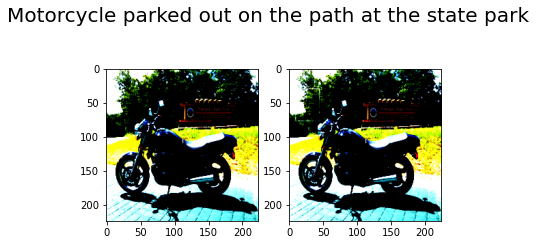

CPU times: user 3.23 s, sys: 58.6 ms, total: 3.29 s
Wall time: 283 ms


In [10]:
%%time
show_sample(dataset_train[0])

In [11]:
trainloader = DataLoader(dataset_train, batch_size=10, shuffle=False, num_workers=2) # VERY important to make sure num_workers > 0.